# Notebook for ADF plot development

The first step is to get ADF into the path and import it. 

In [1]:
#Import standard python modules
import os.path
import sys

#Determine local directory path:
local_path = os.path.abspath('') 
# --> if you are doing this in a .py file:  os.path.dirname(os.path.abspath(__file__))
print(f"Local path appears to be {local_path}")

#set path to ADF lib:
lib_path = os.path.join(local_path,"lib")
print(f"Lib path appears to be {lib_path}")

#set path to ADF plotting scripts directory:
plotting_scripts_path = os.path.join(local_path, "scripts", "plotting")
print(f"The plotting scripts live here, right?: {plotting_scripts_path}")

#Add paths to python path:
sys.path.append(lib_path)
sys.path.append(plotting_scripts_path)

#Import ADF diagnostics object:
from adf_diag import AdfDiag

Local path appears to be /glade/u/home/brianpm/Code/CAM_diagnostics
Lib path appears to be /glade/u/home/brianpm/Code/CAM_diagnostics/lib
The plotting scripts live here, right?: /glade/u/home/brianpm/Code/CAM_diagnostics/scripts/plotting


In [2]:
#Set path to config YAML file:
config_fil = "/glade/u/home/brianpm/drive_diagnostics/test_ca_sc_plot.yaml"

#Initialize ADF object:
adf = AdfDiag(config_fil)

In [3]:
basic_info_dict = adf.read_config_var("diag_basic_info")
basic_info_dict

{'compare_obs': False,
 'create_html': True,
 'obs_climo_loc': '/glade/work/brianpm/observations/climo_files',
 'cam_regrid_loc': '/glade/scratch/brianpm/cam_diag_regrid_files',
 'cam_overwrite_regrid': True,
 'cam_diag_plot_loc': '/glade/scratch/brianpm/cam_diag_plots',
 'use_defaults': True}

In [4]:
baseline_dict = adf.read_config_var("diag_cam_baseline_climo")
baseline_dict

{'calc_cam_climo': True,
 'cam_overwrite_climo': False,
 'cam_case_name': 'b.e20.BHIST.f09_g16.20thC.125.02',
 'cam_hist_loc': '/glade/p/cesm/ADF/b.e20.BHIST.f09_g16.20thC.125.02',
 'cam_climo_loc': '/glade/scratch/brianpm/cam_diag_climo/files/b.e20.BHIST.f09_g16.20thC.125.02',
 'start_year': 1993,
 'end_year': 1996,
 'cam_ts_done': False,
 'cam_ts_save': True,
 'cam_overwrite_ts': False,
 'cam_ts_loc': '/glade/scratch/brianpm/cam_diag_ts_files'}

In [7]:
case_names = adf.get_cam_info('cam_case_name', required=True)  # Loop over these
case_climo_loc = adf.get_cam_info('cam_climo_loc', required=True)
data_name = adf.get_baseline_info('cam_case_name', required=True)
data_list = data_name # should not be needed (?)
data_loc = adf.get_baseline_info("cam_climo_loc", required=True)

In [8]:
basic_info_dict = adf.read_config_var("diag_basic_info")
plot_type = basic_info_dict.get('plot_type', 'png')

import numpy as np

#Set seasonal ranges:
seasons = {"ANN": np.arange(1,13,1),
            "DJF": [12, 1, 2],
            "JJA": [6, 7, 8],
            "MAM": [3, 4, 5],
            "SON": [9, 10, 11]}


In [9]:
import matplotlib as mpl
case_colors = [mpl.cm.tab20(i) for i, case in enumerate(case_names)] # change color for each case

In [99]:
import geocat.comp as gc  # use geocat's interpolation <<--- move outside function

def process_case(climo_loc, latitude, longitude, pressurelevels):
    fils = sorted(list(Path(climo_loc).glob(f"*_T_*.nc")))
    temperature = xr.open_mfdataset(fils)['T'].sel(lat=latitude, lon=longitude).compute()
    fils = sorted(list(Path(climo_loc).glob(f"*_Q_*.nc")))
    vapor = xr.open_mfdataset(fils)['Q'].sel(lat=latitude, lon=longitude).compute()
    fils = sorted(list(Path(climo_loc).glob(f"*_CLDLIQ_*.nc")))
    liquid = xr.open_mfdataset(fils)['CLDLIQ'].sel(lat=latitude, lon=longitude).compute()
    # In one of these, we also need the hybrid-sigma coefficients
    fils = sorted(list(Path(climo_loc).glob(f"*_PS_*.nc")))
    ps_ds = xr.open_mfdataset(fils)
    ps = ps_ds['PS'].sel(lat=latitude, lon=longitude).compute()
    hyam = ps_ds['hyam'].isel(time=0).compute() # drop redundant time dimension
    hybm = ps_ds['hybm'].isel(time=0).compute()
    ps.name = "PS"
    # we aren't done. Interpolate to pressure levels here:
    t_plev = gc.interp_hybrid_to_pressure(temperature, ps, hyam, hybm, new_levels=pressurelevels, lev_dim='lev').compute()
    q_plev = gc.interp_hybrid_to_pressure(vapor, ps, hyam, hybm, new_levels=pressurelevels, lev_dim='lev').compute()
    liq_plev = gc.interp_hybrid_to_pressure(liquid, ps, hyam, hybm, new_levels=pressurelevels, lev_dim='lev').compute()
    t_plev.name = "T"
    q_plev.name = "Q"
    liq_plev.name = 'CLDLIQ'
    # But hold on, we actually want theta, not T:
    p = xr.DataArray(pressurelevels, dims='plev', coords={'plev': t_plev.plev})
    # pressurelevels expected in Pa!
    theta_plev = t_plev * ((100000. / p)**0.2854)  # https://glossary.ametsoc.org/wiki/Potential_temperature &  https://glossary.ametsoc.org/wiki/Poisson_constant
    # Still not done -- average over the area:
    w = np.cos(np.radians(temperature.lat))  # area weighting
    theta_aave = theta_plev.weighted(w).mean(dim=("lat","lon"))  # (12months x pressurelevels.shape[0])
    theta_aave.name = "THETA"
    q_aave = q_plev.weighted(w).mean(dim=("lat","lon"))
    liq_aave = liq_plev.weighted(w).mean(dim=("lat","lon"))
    ps_aave = ps.weighted(w).mean(dim=("lat","lon"))
    return xr.merge([theta_aave, q_aave, liq_aave, ps_aave])

In [111]:
import matplotlib.pyplot as plt
from cycler import cycler

def make_plot(ds1, ds2, caselabels):
    fig, ax = plt.subplots(figsize=(9,4), ncols=3, sharey=True, constrained_layout=True)
    custom_cycler = (cycler(color=['k', 'r', 'y', 'y']) +
                 cycler(lw=[2, 2, 1, 1]))
    [a.set_prop_cycle(custom_cycler) for a in ax]
    if ds1['Q'].max() < 0.1:
        qscale = 1000. # kg/kg -> mg/kg
    else:
        qscale = 1
    if ds1['CLDLIQ'].max() < 0.001:
        lscale = 1000.*1000.  # kg/kg -> ug/kg
    else:
        lscale = 1
    ax[0].plot(ds1['Q']*qscale, ds1['plev']/100, label=caselabels[0])
    ax[0].plot(ds2['Q']*qscale, ds2['plev']/100, label=caselabels[1])
    ax[0].set_xlim([0,25])
    ax[0].set_xlabel("Specific Humidity [g/kg]")
    ax[1].plot(ds1['THETA'], ds1['plev']/100)
    ax[1].plot(ds2['THETA'], ds2['plev']/100)
    ax[1].set_xlabel("Potential Temperature [K]")
    ax[1].set_xlim([275, 325])
    ax[2].plot(ds1['CLDLIQ']*lscale, ds1['plev']/100)
    ax[2].plot(ds2['CLDLIQ']*lscale, ds2['plev']/100)
    ax[2].set_xlabel("Cloud Liquid [$\mu$g/kg]")
    ax[2].set_xlim([0,150])
    ax[2].invert_yaxis()
    ax[0].set_ylabel("Pressure")
    [a.spines['top'].set_visible(False) for a in ax]
    [a.spines['right'].set_visible(False) for a in ax]
    fig.legend(loc='upper left', bbox_to_anchor=(0.0, -0.01))
    return fig, ax


In [114]:
from pathlib import Path
import xarray as xr

# define domain
latslice = slice(20,30)
lonslice = slice(230,240) # Klein&Hartmann 1993, Table 1
levels = 100.*np.arange(600.0, 1015., 15)  # chosen for convenience. Go finer if native grid is finer.


/glade/u/home/brianpm/miniconda3/envs/camdiag/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/u/home/brianpm/miniconda3/envs/camdiag/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/u/home/brianpm/miniconda3/envs/camdiag/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/u/home/brianpm/miniconda3/envs/camdiag/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
/glade/u

case ready


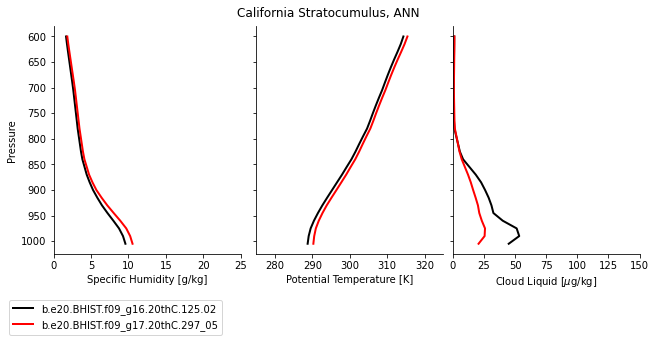

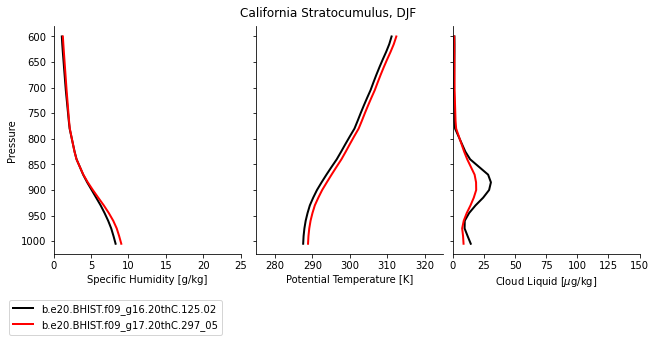

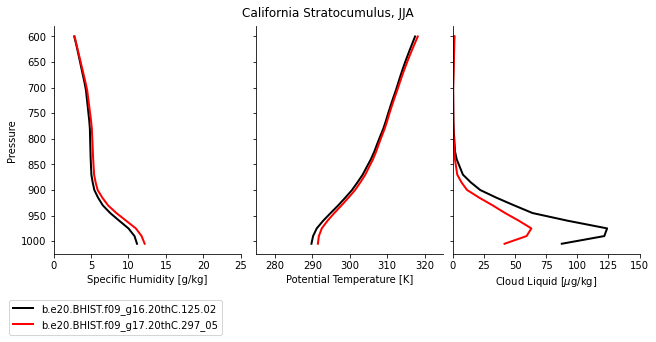

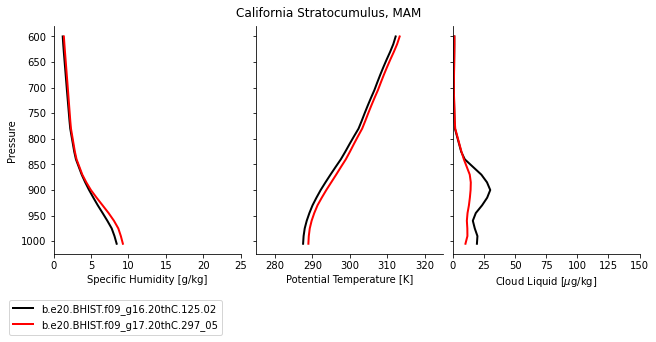

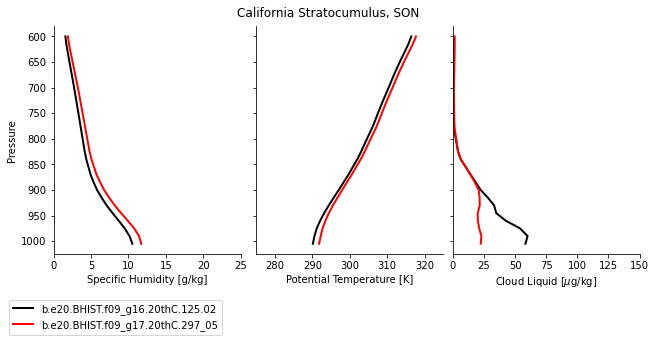

In [115]:

ref_ds = process_case(data_loc, latslice, lonslice, levels)

for i, c in enumerate(case_names):
    case_ds = process_case(case_climo_loc[i], latslice, lonslice, levels)
    print("case ready")
    for s in seasons:
        ref_season = ref_ds.sel(time=seasons[s]).mean(dim='time')
        case_season = case_ds.sel(time=seasons[s]).mean(dim='time')
        # ** Ready to make plot **
        labels = [data_name, c]
        casefig, caseax = make_plot(ref_season, case_season, labels)
        casefig.suptitle(f"California Stratocumulus, {s}")
        plt.show()
        


In [98]:
ref_ds['THETA']

<xarray.DataArray 'THETA' (time: 12, plev: 21)>
array([[84.87203153, 84.57804923, 84.23006494, 83.87600209, 83.56259342,
        83.25567614, 82.84731755, 82.47257181, 82.12851552, 81.73913925,
        81.36143104, 81.0091173 , 80.50896467, 80.00986548, 79.45188609,
        78.84466004, 78.25279737, 77.79345913, 77.4973393 , 77.3411937 ,
        77.26928125],
       [84.62211845, 84.34350377, 84.00838927, 83.66661378, 83.36511129,
        83.06735607, 82.6571945 , 82.28062817, 81.93473621, 81.53381241,
        81.14231543, 80.77642367, 80.22112476, 79.66177697, 79.07310851,
        78.46513765, 77.97033803, 77.60618182, 77.34502748, 77.16329319,
        77.07151468],
       [84.69128126, 84.40325553, 84.05494955, 83.70010707, 83.38587084,
        83.07337215, 82.65228425, 82.2650275 , 81.90866454, 81.50298907,
        81.10980089, 80.74224252, 80.19077303, 79.6412006 , 79.07489835,
        78.50284014, 78.0306564 , 77.66953675, 77.42227572, 77.26087044,
        77.15763522],
       [85.0960781 , 84.81288987, 84.47324151, 84.12753259, 83.82236881,
        83.51785362, 83.0956282 , 82.70739104, 82.35019073, 81.96685115,
        81.59901505, 81.25644066, 80.71950532, 80.17927795, 79.57504413,
        78.92302643, 78.32841798, 77.86049242, 77.5278116 , 77.32112858,
        77.22501258],
...
       [87.39889586, 87.01988624, 86.52461717, 86.02850774, 85.57735695,
        85.14056471, 84.67480322, 84.24444742, 83.84653551, 83.46005707,
        83.09968269, 82.76079489, 82.36327661, 81.98821596, 81.51820048,
        81.00228251, 80.37711539, 79.6503384 , 78.90874481, 78.36660573,
        78.15806518],
       [86.5847504 , 86.26522361, 85.85598343, 85.44379082, 85.07427572,
        84.70285042, 84.24999839, 83.83214472, 83.44625304, 83.05426525,
        82.68628638, 82.34248611, 81.93246883, 81.54225409, 81.0863648 ,
        80.59605687, 80.02729778, 79.41656441, 78.82452928, 78.31579081,
        78.00710048],
       [85.75318927, 85.44476364, 85.07754846, 84.71059242, 84.38492491,
        84.0565404 , 83.62643213, 83.2306419 , 82.86619153, 82.45453912,
        82.06080146, 81.69226101, 81.18678645, 80.69606125, 80.14475789,
        79.5592361 , 78.98739434, 78.5334685 , 78.20138152, 77.96602228,
        77.83297477],
       [85.14197962, 84.85625891, 84.51585397, 84.16831094, 83.86137359,
        83.55868424, 83.13762168, 82.75053466, 82.39447237, 81.99796815,
        81.61353451, 81.25467876, 80.75107405, 80.24723492, 79.68497172,
        79.07214806, 78.47750129, 77.99874023, 77.6712709 , 77.48534576,
        77.39567716]])
Coordinates:
  * plev     (plev) float64 5e+04 5.25e+04 5.5e+04 ... 9.5e+04 9.75e+04 1e+05
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [117]:
plot_type = adf.get_basic_info('plot_location', required=False)

In [119]:
print(plot_type)

None


In [120]:
plot_type is None

True